## Set Up AstraDB to store docs

I want to utilize AstraDB as the DB for storing documents as the docs are pretty large.

In [2]:
from astrapy import DataAPIClient
from dotenv import load_dotenv
import os
load_dotenv()

ENDPOINT = os.getenv("ASTRA_DB_API_ENDPOINT")
TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
# Initialize the client

client = DataAPIClient()
db = client.get_database(
  ENDPOINT,
  token=TOKEN,
)
print(f"Connected to Astra DB: {db.name()}")
print(f"Collections: {db.list_collection_names()}")


Connected to Astra DB: stat_rag_docs


DataAPIHttpException: Server error '503 Service Unavailable' for url 'https://1a333795-2742-4a30-ba2d-24bf593d4738-us-east1.apps.astra.datastax.com/api/json/v1/default_keyspace'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/503

# Data Processor Construction

In [3]:
from logging import raiseExceptions
from langchain_astradb import AstraDBLoader
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os

doc_path = '../RAG_Docs'

In [28]:
import re
import unicodedata
from collections import Counter
import numpy as np
# Helped by ChatGPT to generalize cleaning steps

def clean_encoding(text):
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r'[\x00-\x08\x0b-\x0c\x0e-\x1f]', '', text)
    return text

def frequent(lines, pages, freq_threshold=0.7):
    counts = Counter(l.strip().lower() for l in lines if l.strip())
    return {
        l for l, c in counts.items()
        if c / len(pages) >= freq_threshold
    }

def strip_headers_footers(docs, top_n=2, bottom_n=2, freq_threshold=0.7):
    pages = [d.page_content.splitlines() for d in docs]

    top_lines, bottom_lines = [], []
    for lines in pages:
        top_lines.extend(lines[:top_n])
        bottom_lines.extend(lines[-bottom_n:])

    bad_top = frequent(top_lines, pages=pages, freq_threshold=freq_threshold)
    bad_bottom = frequent(bottom_lines, pages=pages, freq_threshold=freq_threshold)

    for d in docs:
        lines = d.page_content.splitlines()
        lines = [
            l for l in lines
            if l.strip().lower() not in bad_top
            and l.strip().lower() not in bad_bottom
        ]
        d.page_content = "\n".join(lines)

    return docs

def normalize_whitespace(text):
    text = re.sub(r'[ \t]+', ' ', text)
    text = re.sub(r'\n{3,}', '\n\n', text)
    text = re.sub(r'(?:\n\s*){3,}', '\n\n', text)
    text = re.sub(r'\.{4,}', '.', text) # Avoiding ... case
    return text.strip()

def preprocess_docs(docs):
    for d in docs:
        d.page_content = clean_encoding(d.page_content)

    docs = strip_headers_footers(docs)

    for d in docs:
        d.page_content = normalize_whitespace(d.page_content)

    return docs

# My work

def path_validate(path):
    if not os.path.exists(path):
        return False
    else:
        return True


class DocIngestion:
    def __init__(self, docs_path: str, chunk_size=100, chunk_overlap=20):
        self.docs_path = docs_path if path_validate(docs_path) else raiseExceptions
        self.chunk_size = -1
        self.chunk_overlap = -1
        self.splitter = None
        self.update_splitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    def batch_ingest(self):
        for file in [f for f in os.listdir(self.docs_path) if not f.startswith('.')]: # Get all files name for ingestion
            res = self.individual_ingest(file)
            return res
        return None

    # Return True if the file is loaded successfully, False otherwise
    def individual_ingest(self, filename: str):
        if path_validate(os.path.join(self.docs_path, filename)):
            loader = PyPDFLoader(os.path.join(self.docs_path, filename))
            document = loader.load()
            cleaned_doc = preprocess_docs(document)
            return self.chunking(cleaned_doc)
        else:
            return None

    def chunking(self, doc):
        chunks = self.splitter.split_documents(doc)
        valid_chunks = [doc for doc in chunks if len(doc.page_content) > 50]
        print(f"Found total {len(chunks)} chunks")
        print(f"Found {len(valid_chunks)} valid (len > 50) chunks")
        print(f"Average chunk size: {np.mean([len(doc.page_content) for doc in valid_chunks])}")
        return valid_chunks

    def update_splitter(self, chunk_size=-1, chunk_overlap=-1):

        if chunk_size == -1 and chunk_overlap == -1:
            print("Nothing to update")
            return

        new_size = chunk_size if chunk_size != -1 else self.chunk_size
        new_overlap = chunk_overlap if chunk_overlap != -1 else self.chunk_overlap

        if new_size <= new_overlap:
            print(f"Error: Chunk size ({new_size}) must be greater than chunk overlap ({new_overlap}). Update aborted.")
            return

        self.chunk_size = new_size
        self.chunk_overlap = new_overlap

        try:
            self.splitter = RecursiveCharacterTextSplitter(
                separators=["\n\n", "\n", " ", ""],
                chunk_size=self.chunk_size,
                chunk_overlap=self.chunk_overlap,
            )
            print(f"Current splitter: name={self.splitter.__class__}, chunk_size={self.chunk_size}, chunk_overlap={self.chunk_overlap}")
        except Exception as e:
            print(f"Unexpected error updating splitter: {e}")

In [29]:
ingestor = DocIngestion("../RAG_Docs", chunk_size=600, chunk_overlap=100)
# chunks = ingestor.individual_ingest("assumptions.pdf")

def test_chunking(filename):
    book = ingestor.individual_ingest(filename)
    for i in range(5):
        content = book[i].page_content
        print(f"=============== Chunk {i + 1} ({len(content)} characters) ==============")
        print(content)
        print("\n\n")

Current splitter: name=<class 'langchain_text_splitters.character.RecursiveCharacterTextSplitter'>, chunk_size=600, chunk_overlap=100


In [38]:
ingestor.individual_ingest("assumptions.pdf")[0].metadata.keys()

Found total 185 chunks
Found 184 valid (len > 50) chunks
Average chunk size: 464.5054347826087


dict_keys(['producer', 'creator', 'creationdate', 'author', 'category', 'comments', 'company', 'keywords', 'moddate', 'sourcemodified', 'subject', 'title', 'source', 'total_pages', 'page', 'page_label'])

In [6]:
test_chunking("assumptions.pdf")

Found total 185 chunks
Found 184 valid (len > 50) chunks
Average chunk size: 464.5054347826087
=============== Chunk 1 (283 characters) ==============
Copyright @c 2012 by G. David Garson and Statistical Associates Publishing Page 1 
 
Statistical 
Associates 
Publishing 
____________ 
Blue Book Series 

TESTING STATISTICAL ASSUMPTIONS 
By G. David Garson 
North Carolina State University 
School of Public and International Affairs



=============== Chunk 2 (81 characters) ==============
Copyright @c 2012 by G. David Garson and Statistical Associates Publishing Page 2



=============== Chunk 3 (508 characters) ==============
@c 2012 by G. David Garson and Statistical Associates Publishing. All rights reserved worldwide in all 
media. 
The author and publisher of this eBook and accompanying materials make no representation or 
warranties with respect to the accuracy, applicability, fitness, or completeness of the contents of this 
eBook or accompanying materials. The author and publish

In [52]:
test_chunking("BayesianGroupModeling.pdf")

Found total 172 chunks
Found 172 valid (len > 50) chunks
Average chunk size: 540.0290697674419
=============== Chunk 1 (588 characters) ==============
Bayesian model selection for group studies — Revisited
L. Rigoux a, K.E. Stephan b,c,K . J .F r i s t o nb,J .D a u n i z e a ua,b,⁎
a Brain and Spine Institute, Paris, France
b Wellcome Trust Centre for Neuroimaging, University College London, UK
c Translational Neuromodeling Unit (TNU), Institute for Biomedical Engineering, University of Zurich & ETH Zurich, Switzerland
abstractarticle info
Article history:
Accepted 29 August 2013
Available online 7 September 2013
Keywords:
Statistical risk
Exceedance probability
Between-condition comparison
Between-group comparison
Mixed effects



=============== Chunk 2 (535 characters) ==============
Exceedance probability
Between-condition comparison
Between-group comparison
Mixed effects
Random effects
DCM
In this paper, we revisit the problem of Bayesian model selection (BMS) at the group level.

In [53]:
test_chunking("ProcessModeling-NISTHandbook.pdf")

Found total 192 chunks
Found 192 valid (len > 50) chunks
Average chunk size: 496.859375
=============== Chunk 1 (596 characters) ==============
4. Process Modeling
http://www.itl.nist.gov/div898/handbook/pmd/pmd.htm[6/27/2012 2:16:03 PM]
 
4. Process Modeling
The goal for this chapter is to present the background and specific analysis
techniques needed to construct a statistical model that describes a particular
scientific or engineering process. The types of models discussed in this
chapter are limited to those based on an explicit mathematical function.
These types of models can be used for prediction of process outputs, for
calibration, or for process optimization.
1. Introduction
1. Definition
2. Terminology
3. Uses
4. Methods



=============== Chunk 2 (551 characters) ==============
1. Introduction
1. Definition
2. Terminology
3. Uses
4. Methods
2. Assumptions
1. Assumptions
3. Design
1. Definition
2. Importance
3. Design Principles
4. Optimal Designs
5. Assessment
4. Analysis
1.

# Embeddings

In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [13]:
embedding = model.encode('Hello my name is an ugly name'.split())

In [15]:
embedding

array([[-0.0627718 ,  0.05495884,  0.05216483, ...,  0.05090599,
         0.05148358,  0.00709218],
       [-0.02438824,  0.00035651,  0.02360094, ...,  0.03700329,
        -0.06691144,  0.01926724],
       [-0.1606512 ,  0.04766631, -0.09563401, ..., -0.02025016,
         0.0317325 ,  0.03087449],
       ...,
       [-0.04235605,  0.04257292, -0.03373828, ...,  0.03536008,
        -0.00824193,  0.10022207],
       [-0.03307104,  0.06964022, -0.02013162, ..., -0.07463824,
         0.04326566,  0.04075326],
       [-0.1606512 ,  0.04766631, -0.09563401, ..., -0.02025016,
         0.0317325 ,  0.03087449]], shape=(7, 384), dtype=float32)

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(embedding)

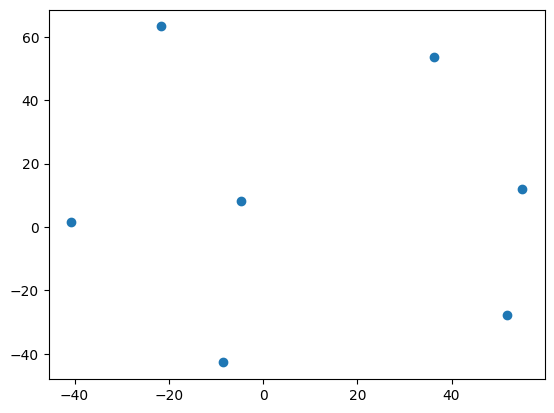

In [27]:
import matplotlib.pyplot as plt

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])